# Latent Dirichlet Allocation (LDA)
- **Content**: Topic Modeling using LDA
- **Author**: Noor de Bruijn
- **Last edited**: Thursday, June 19, 2025

## Install packages

In [2]:
!pip install -q numpy==1.24.4
!pip install -q pandas==2.2.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.


In [5]:
#Check Numpy version
import numpy as np
print(f"Numpy version: {np.__version__}")

import pandas as pd
print(f"Pandas version: {pd.__version__}")

Numpy version: 1.24.4
Pandas version: 2.2.1


### Open file

In [26]:
#Test data
df_copy = pd.DataFrame({
    "answer": [
        "Alice's work was excellent.\nVery consistent.",
        "Bob did a great job.\nHe's always on time.",
        "Carol's input was helpful.\nGood team player.",
        "Dave works independently.\nStrong communicator.",
        "Eve is proactive and reliable.\nGreat attitude.",
        "Frank delivers results.\nMeets deadlines.",
        "Grace takes initiative.\nVery skilled.",
        "Hank is a team player.\nVery positive.",
        "Ivy is creative.\nStrong problem-solving.",
        "Jake shows leadership.\nSupports others."
    ]
})

# Mock name list for testing
NAMES = {"Alice", "Bob", "Carol", "Dave", "Eve", "Frank", "Grace", "Hank", "Ivy", "Jake"}

### Install packages with dependencies

In [5]:
!pip install -q gensim
!pip install -q nlp
!pip install -q nltk
!pip install -q pyLDAvis
!pip install -q matplotlib
!pip install -q spacy

#Downloading pre-trained model
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 196.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [40]:
##
import os
import re
import sys
import time 

##
import gensim
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing
import pyLDAvis
import nlp
import spacy

from gensim.corpora import Dictionary
from gensim.models import LdaModel, LsiModel, HdpModel
from gensim.models import Phrases
from IPython.display import HTML, display
from multiprocessing import Process, Queue
import pyLDAvis.gensim_models
from spacy import displacy

print("Success")

Success


In [27]:
#Print statement to see versions
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Gensim version:", gensim.__version__)
print(f"pyLDAvis version: {pyLDAvis.__version__}")

Python version: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:45:41) [GCC 13.3.0]
Numpy version: 1.24.4
Pandas version: 2.2.1
Gensim version: 4.3.3
pyLDAvis version: 2.1.2


## Check cwd and Python executable/version

In [ ]:
#Check current working directory
print("Current working directory:")
print(os.getcwd())

#Check virtual environment path
print("\n Python executable (venv path):")
print(sys.executable)

#Check Python version
print("\nPython version:")
print(sys.version)

## File: NAMES

In [29]:
#Get a list of existed names (over 18,000) from names.txt file
with open('names.txt', 'r') as file:
    NAMES = set(file.read().splitlines())

## Step 1. Text cleaning

In [30]:
#Define functions
def clean_text(text):
    text = re.sub(r'\s*\\n\s*', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def replace_edge_quotes(text):
    text = text.strip()
    if text.startswith('"') and text.endswith('"'):
        text = "'" + text[1:-1] + "'"
    return text

def normalize_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def find_and_remove_names(text):
    if not isinstance(text, str):
        return text, []
    matches = re.findall(r"\b[A-Z][a-z]+(?:'s)?\b", text)
    matches_singular = set(name.replace("'s", "") for name in matches)
    found_names = [name for name in matches_singular if name in NAMES]
    for name in found_names:
        text = re.sub(r"\b" + re.escape(name) + r"(?:'s)?\b", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text, found_names

def process_chunk(df_chunk, output_queue):
    df_chunk['answer'] = df_chunk['answer'].apply(clean_text)
    df_chunk[['answer_cleaned', 'found_names']] = df_chunk['answer'].apply(find_and_remove_names).apply(pd.Series)
    df_chunk['answer_cleaned'] = df_chunk['answer_cleaned'].apply(replace_edge_quotes)
    df_chunk['answer_cleaned'] = df_chunk['answer_cleaned'].apply(normalize_spaces)
    output_queue.put(df_chunk)

#main() orchestrates the multiprocessing workflow
def main():
    num_processes = multiprocessing.cpu_count()
    chunk_size = len(df_copy) // num_processes + 1
    processes = []
    output_queue = Queue()
    data_chunks = [df_copy.iloc[i:i + chunk_size].copy() for i in range(0, len(df_copy), chunk_size)]

    for chunk in data_chunks:
        p = Process(target=process_chunk, args=(chunk, output_queue))
        processes.append(p)
        p.start()

    for p in processes:
        p.join()

    results = []
    while not output_queue.empty():
        results.append(output_queue.get())

    df_result = pd.concat(results, ignore_index=True)
    return df_result

#Running the multiprocessing workflow
if __name__ == '__main__':
    start_time = time.time()
    df_result = main()
    end_time = time.time()
    print(df_result[['answer', 'answer_cleaned', 'found_names']].head(5))

    print(f"\nExecution time (parallel): {end_time - start_time:.4f} seconds")

                                           answer  \
0    Alice's work was excellent. Very consistent.   
1       Bob did a great job. He's always on time.   
2    Carol's input was helpful. Good team player.   
3  Dave works independently. Strong communicator.   
4  Eve is proactive and reliable. Great attitude.   

                               answer_cleaned found_names  
0        work was excellent. Very consistent.     [Alice]  
1            did a great job. always on time.   [Bob, He]  
2        input was helpful. Good team player.     [Carol]  
3   works independently. Strong communicator.      [Dave]  
4  is proactive and reliable. Great attitude.       [Eve]  

Execution time (parallel): 0.0448 seconds


## Step 2. Apply NLP Model (spaCy) for linguistic annotation

In [31]:
#Load pre-trained language model
nlp = spacy.load('en_core_web_sm')

#Create copy
doc = df_result['answer_cleaned'].copy()

#Apply nlp
docs = doc.apply(nlp)

#### I. POS-Tagging

In [32]:
#Print first sentence to see if it worked
one_sentence = docs.iloc[2]  

for token in one_sentence:
    print(token.text, token.pos_, token.tag_)

input NOUN NN
was AUX VBD
helpful ADJ JJ
. PUNCT .
Good ADJ JJ
team NOUN NN
player NOUN NN
. PUNCT .


#### II. NER-Tagging

In [33]:
#Loop over each individual token
for token in one_sentence:
    print(token.text, token.ent_type_)

input 
was 
helpful 
. 
Good 
team 
player 
. 


In [34]:
#Loop over each recognized named entity
for ent in one_sentence.ents:
    print(ent.text, ent.label_)

In [41]:
#Display named entities
displacy.render(one_sentence, style='ent', jupyter=True)

#### III. Dependency Parsing

In [42]:
#Iterates over noun phrases (noun chunks) in the doc
for chunk in one_sentence.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

input input nsubj was
Good team player player ROOT player


In [43]:
#Iterates over every individual token (word or punctuation mark).
for token in one_sentence:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
         [child for child in token.children])

input nsubj was AUX []
was ROOT was AUX [input, helpful, .]
helpful acomp was AUX []
. punct was AUX []
Good amod player NOUN []
team compound player NOUN []
player ROOT player NOUN [Good, team, .]
. punct player NOUN []


In [44]:
#Create visual
displacy.render(one_sentence, style='dep', jupyter=True, options={'distance':90})

## Step 3. LDA

### I. Create lists of words
**Explanation**: <br>
LDA works on bags of words, not structured linguistic objects. <br>
You can’t feed a Doc directly into LDA — it needs simple word lists (one per document). <br>

In [45]:
texts = []

for doc in docs:
    article = []
    for token in doc:
        # Skip tokens that are whitespace or unwanted
        if token.is_space or token.is_punct or token.is_stop or token.like_num or token.text == 'I':
            continue
        cleaned_token = token.lemma_.strip()
        if cleaned_token:  # Skip any remaining empty strings
            article.append(cleaned_token)
    
    texts.append(article)

print(texts[0])

#Create bigrams
bigram = gensim.models.phrases.Phrases(texts)
texts = [bigram[line] for line in texts]

['work', 'excellent', 'consistent']


### II. Create dictionary and corpus

In [46]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
print(corpus[4])

[(3, 1), (14, 1), (15, 1), (16, 1)]


### III. Run LdaModel() + visualize topics

In [47]:
lda_model = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)
lda_model.show_topics()

[(0,
  '0.180*"time" + 0.180*"job" + 0.180*"great" + 0.016*"work" + 0.016*"team" + 0.016*"strong" + 0.016*"leadership" + 0.016*"initiative" + 0.016*"positive" + 0.016*"take"'),
 (1,
  '0.032*"great" + 0.032*"team" + 0.032*"work" + 0.032*"player" + 0.032*"strong" + 0.032*"skilled" + 0.032*"job" + 0.032*"take" + 0.032*"problem" + 0.032*"proactive"'),
 (2,
  '0.155*"great" + 0.155*"attitude" + 0.155*"reliable" + 0.155*"proactive" + 0.014*"team" + 0.014*"work" + 0.014*"strong" + 0.014*"job" + 0.014*"skilled" + 0.014*"player"'),
 (3,
  '0.149*"strong" + 0.078*"solving" + 0.078*"independently" + 0.078*"communicator" + 0.078*"creative" + 0.078*"work" + 0.078*"problem" + 0.078*"skilled" + 0.078*"take" + 0.078*"initiative"'),
 (4,
  '0.180*"show" + 0.180*"support" + 0.180*"leadership" + 0.016*"great" + 0.016*"team" + 0.016*"strong" + 0.016*"job" + 0.016*"work" + 0.016*"player" + 0.016*"positive"'),
 (5,
  '0.180*"work" + 0.180*"excellent" + 0.180*"consistent" + 0.016*"great" + 0.016*"player" + 

In [48]:
print(f"Version pyLDAvis: {pyLDAvis.__version__}")
print(f"Version Python: {pd.__version__}")

Version pyLDAvis: 2.1.2
Version Python: 2.2.1


Topic 0


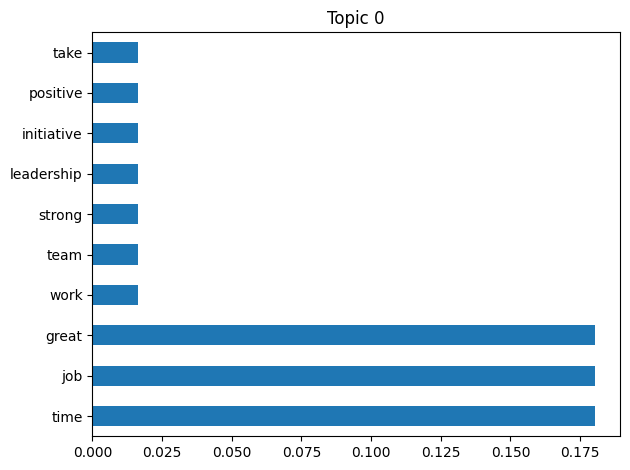

Topic 1


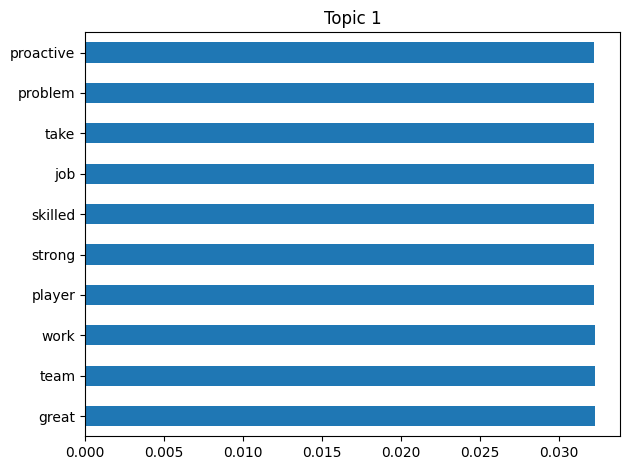

Topic 2


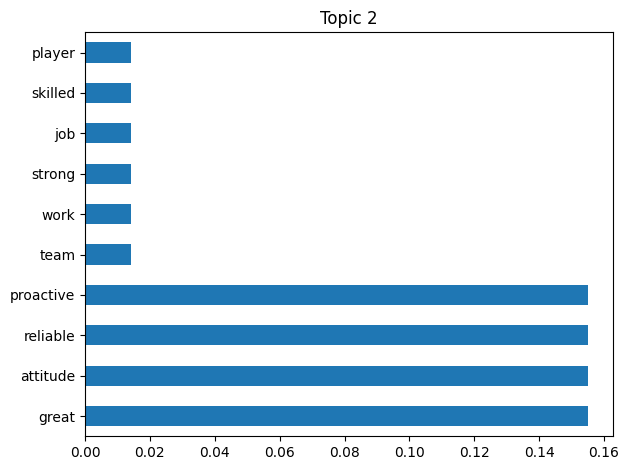

Topic 3


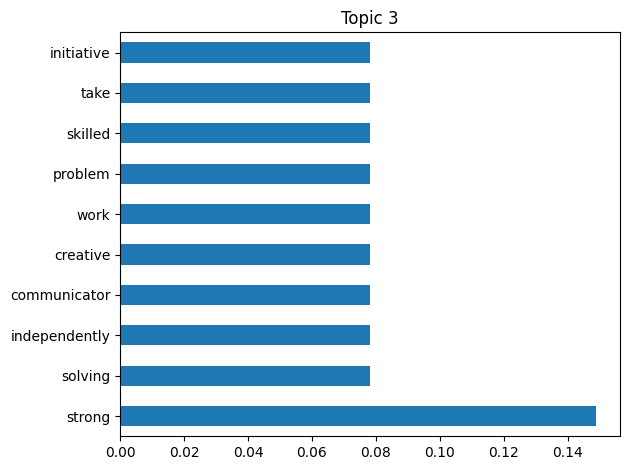

Topic 4


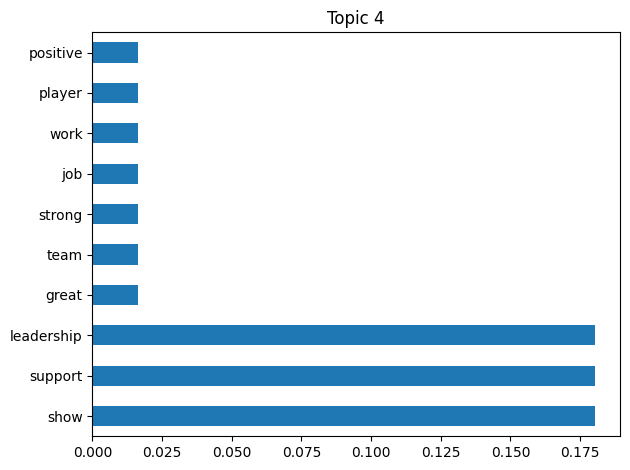

Topic 5


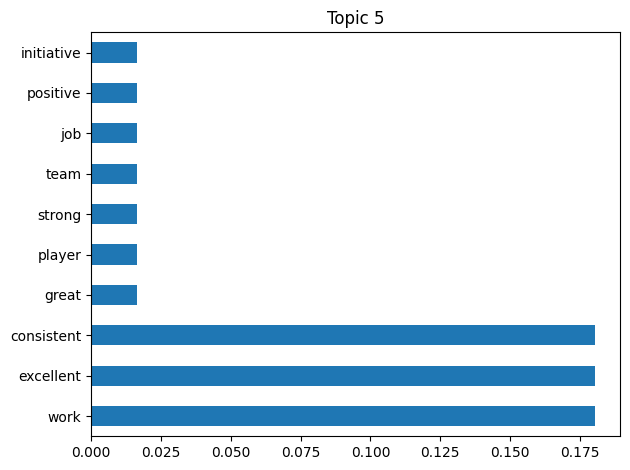

Topic 6


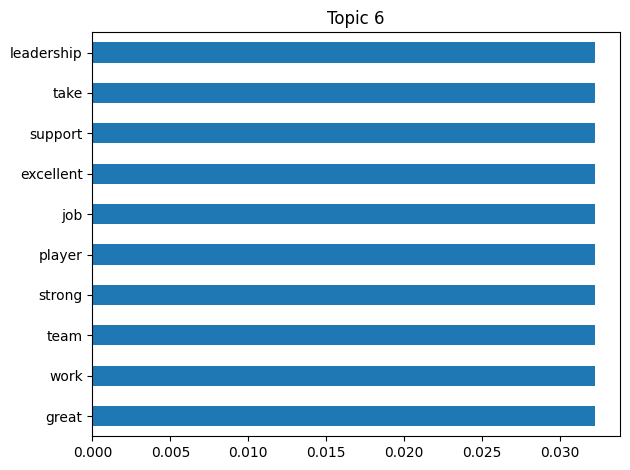

Topic 7


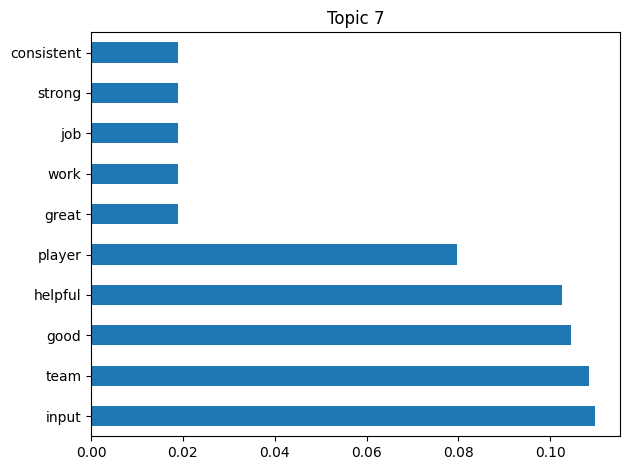

Topic 8


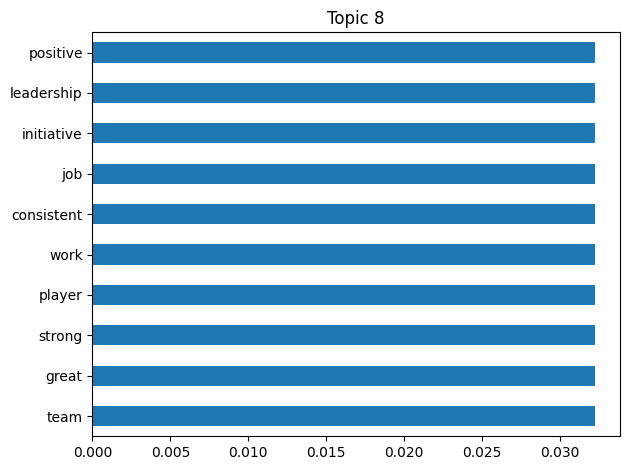

Topic 9


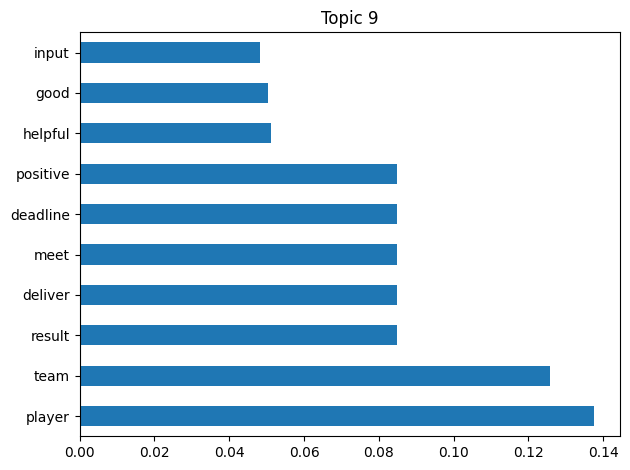

In [49]:
for idx, topic in lda_model.show_topics(formatted=False):
    print(f"Topic {idx}")
    words = dict(topic)
    pd.Series(words).nlargest(10).plot(kind='barh', title=f"Topic {idx}")
    plt.tight_layout()
    plt.show()

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

### IV. LSI
LSI — Latent Semantic Indexing

In [51]:
lsi_model = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
lsi_model.show_topics(num_topics=5)

[(0,
  '0.551*"team" + 0.551*"player" + 0.341*"helpful" + 0.341*"input" + 0.341*"good" + 0.211*"positive" + 0.000*"creative" + 0.000*"great" + 0.000*"solving" + 0.000*"problem"'),
 (1,
  '0.580*"strong" + 0.465*"work" + 0.322*"communicator" + 0.322*"independently" + 0.258*"problem" + 0.258*"solving" + 0.258*"creative" + 0.143*"consistent" + 0.143*"excellent" + 0.000*"great"'),
 (2,
  '0.640*"great" + 0.396*"reliable" + 0.396*"proactive" + 0.396*"attitude" + 0.245*"job" + 0.245*"time" + 0.000*"meet" + 0.000*"deliver" + 0.000*"deadline" + 0.000*"result"'),
 (3,
  '-0.500*"result" + -0.500*"meet" + -0.500*"deliver" + -0.500*"deadline" + 0.000*"great" + 0.000*"proactive" + 0.000*"attitude" + 0.000*"reliable" + -0.000*"leadership" + -0.000*"show"'),
 (4,
  '-0.487*"work" + 0.391*"problem" + 0.391*"solving" + 0.391*"creative" + -0.313*"consistent" + -0.313*"excellent" + 0.217*"strong" + -0.174*"independently" + -0.174*"communicator" + -0.000*"good"')]

### V. HDP 
HDP - Hierarchical Dirichlet Process

In [52]:
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
hdp_model.show_topics()[:5]

[(0,
  '0.093*reliable + 0.071*problem + 0.066*input + 0.062*job + 0.061*creative + 0.052*take + 0.049*consistent + 0.047*positive + 0.045*independently + 0.041*meet + 0.041*strong + 0.037*show + 0.036*support + 0.029*skilled + 0.027*excellent + 0.026*player + 0.023*proactive + 0.021*great + 0.020*deliver + 0.019*helpful'),
 (1,
  '0.146*solving + 0.111*deliver + 0.087*strong + 0.060*input + 0.060*great + 0.059*initiative + 0.054*skilled + 0.052*team + 0.049*time + 0.041*communicator + 0.035*consistent + 0.030*good + 0.028*creative + 0.028*meet + 0.021*helpful + 0.020*result + 0.019*independently + 0.016*attitude + 0.012*support + 0.010*show'),
 (2,
  '0.150*skilled + 0.134*creative + 0.086*positive + 0.072*show + 0.057*team + 0.046*strong + 0.036*problem + 0.035*attitude + 0.034*deliver + 0.033*consistent + 0.029*initiative + 0.029*excellent + 0.028*great + 0.028*input + 0.026*take + 0.026*helpful + 0.025*player + 0.020*good + 0.019*reliable + 0.016*solving'),
 (3,
  '0.189*independen